# XAUUSD

In [2]:
import quandl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import os

import warnings
import logging

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [3]:
xau_ratios = [
    "WGC/GOLD_DAILY_USD"
#     "WGC/GOLD_DAILY_EUR",
#     "WGC/GOLD_DAILY_TRY",
#     "WGC/GOLD_DAILY_JPY",
#     "WGC/GOLD_DAILY_GBP",
#     "WGC/GOLD_DAILY_CAD",
#     "WGC/GOLD_DAILY_CHF",
#     "WGC/GOLD_DAILY_VND",
#     "WGC/GOLD_DAILY_KRW",
#     "WGC/GOLD_DAILY_RUB",
#     "WGC/GOLD_DAILY_AUD",
]

economic_indc = []

### Quandl data terms

Anyone seeking to use this code must first apply for an account with [Quandl](https://www.quandl.com) in order to receive an valid authetitciation key.

In [4]:
DIR_NAME = os.path.abspath(os.path.join(os.getcwd(), '..'))
FILEPATH = os.path.join(DIR_NAME, "auth.txt")

with open(FILEPATH, "r") as f:
    authtoken = f.read();

# Retrieve Data

In [5]:
xau_df_dict = {}

for ratio in tqdm(xau_ratios):
    name = ratio.lower().replace("/", "_")

    # get the ratio dataframe
    df = quandl.get(ratio, authtoken=authtoken, start_date = "1979-01-01")
    df.columns = ["price"]
    
    # check for missing business days 
    if pd.infer_freq(df.index) != "B":
        logging.warn("Datetime frequency is not Business Days")
    
    xau_df_dict[name] = df

100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


## Volatility

In [6]:
annualization_factor = 252.
window_size = [5, 20, 60, 120, 252]

for ratio, df in tqdm(xau_df_dict.items()):
    start_date, end_date = df.index[0], df.index[-1]
    full_range = pd.date_range(start_date, end_date, freq = "B")
    
    if not np.array_equal(df.index, pd.date_range(start_date, end_date, freq="B")):
        logging.warning("\n{} is missing business days".format(ratio))

    for window in window_size:
        df['{}d_market_vol'.format(window)] = np.sqrt(
            (annualization_factor/window) * df['price'].rolling(window).var(ddof=0))

100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


## Quandl Features

In [7]:
features = [
    "FRED/T10Y2Y",
    "RATEINF/INFLATION_USA",
]

In [8]:
for ratio, df in xau_df_dict.items():
    for feature in features:
        col_name = feature.lower().replace('/', '_')
        
        # get quandl features. `end_date` is set to df.index[-1] to match the price data
        data = quandl.get(feature, authtoken=authtoken, start_date = "1979-01-01", end_date = df.index[-1])
        start_date, end_date = data.index[0], data.index[-1]

        # Some features contain missing data. To best simulate how the data would be ingested
        # realtime, the current value is forward filled. This achieved by resampling.
        if not np.array_equal(data.index, pd.date_range(start_date, end_date, freq="B")):
            logging.warning("\n\t{} is missing business days".format(feature))
                    
        df[col_name] = data
    
    df[:] = df.ffill()

	FRED/T10Y2Y is missing business days
	RATEINF/INFLATION_USA is missing business days


## Technical indicator features

In [36]:
import talib

technical_indicators= {
    "MACD" : ("macd", "macdsignal", "macdhist"),
    "STOCHRSI" : ("fastk", "fastd"),
    "MOM" : ("real"),
    "APO" : ('real')
}

for ratio, df in xau_df_dict.items():
    
    # talib requires market price data. starting price of $1 is taken
    # since absolute values are not important (preprocess scaling)
    price = df['price'].values

    for indicator, indicator_type in technical_indicators.items():
        # Return the result for each indicator
        result = getattr(talib, indicator)(price)

        if isinstance(result, np.ndarray):
            df[indicator.lower()] = result
        else:
            for f, r in zip(indicator_type, result):
                if f == indicator.lower():
                    df["{}".format(indicator.lower())] = r
                else:
                    df["{}_{}".format(indicator.lower(), f)] = r

,macd_macdsignal,macd
Date,,
1980-02-01,71.974419,47.311716
1980-02-04,66.202342,43.114033
1980-02-05,61.024099,40.311130
1980-02-06,56.781196,39.809583
1980-02-07,53.061994,38.185185
1980-02-08,49.629395,35.899002
1980-02-11,46.738419,35.174511
1980-02-12,43.976672,32.929688
1980-02-13,41.376367,30.975143


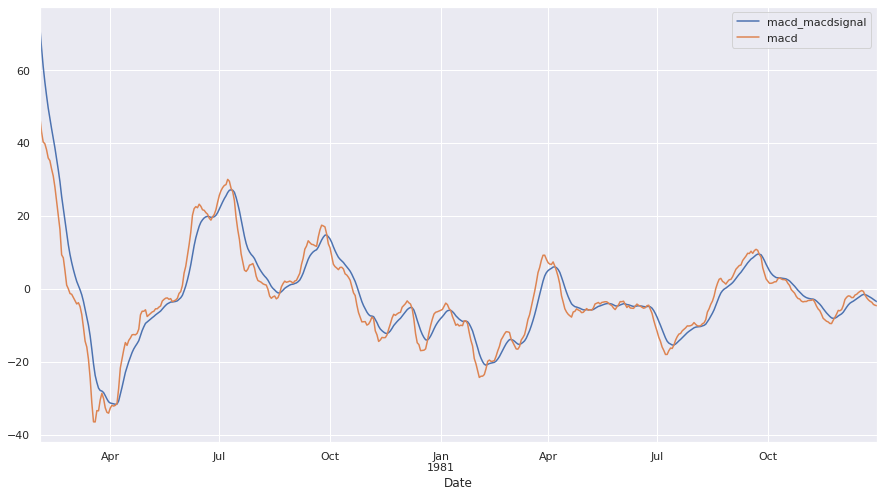

In [191]:
df = split_data['X_train']
df = df[['macd_macdsignal', 'macd']]
sns.set_style('dark')
sns.set(rc={'figure.figsize':(15, 8)})


df['1980':'1981'].plot()

s_2 = df['macd_macdsignal']
s_1 = df['macd']

uptrend = (s_1 < s_2) & (s_1 >= s_2)

dates_increasing = df.index[fast_greater_slow]
dates_decreasing = df.index[~fast_greater_slow]

# class MacdCross(BaseEstimator, TransformerMixin):
#     def __init__():
        
#     def fit(self, X, y= None):
#         return self
    
#     def transform(self, X, y=None):
#         fast, slow = X['macd_macdsignal'], X['macd']
        
#         uptrend = (fast < )
        
uptrend = s_1 > s_2
downtrend = s_1 < s_2

df['1980':'1981'].head(50)

In [192]:
s_1.index[uptrend]

DatetimeIndex(['1980-04-07', '1980-04-08', '1980-04-09', '1980-04-10',
               '1980-04-11', '1980-04-14', '1980-04-15', '1980-04-16',
               '1980-04-17', '1980-04-18',
               ...
               '2007-09-21', '2007-09-24', '2007-09-25', '2007-09-26',
               '2007-09-27', '2007-09-28', '2007-10-01', '2007-10-02',
               '2007-10-15', '2007-10-16'],
              dtype='datetime64[ns]', name='Date', length=3723, freq=None)

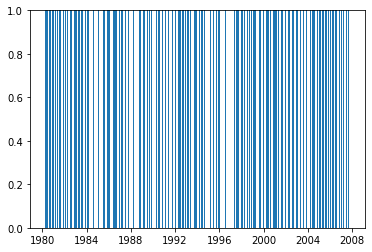

In [98]:
ind = df.index[fast_greater_slow]


np.split(ind, dates[~((dates.shift(5) == dates) | (dates.shift(-5) == dates))].index)
for region in np.split(ind, dates[~((dates.shift(5) == dates) | (dates.shift(-5) == dates))].index):
    plt.axvspan(region[0], region[-1])

In [40]:
split_data['X_train'].columns

Index(['5d_market_vol', '20d_market_vol', '60d_market_vol', '120d_market_vol',
       '252d_market_vol', 'fred_t10y2y', 'rateinf_inflation_usa', 'macd_macd',
       'macd_macdsignal', 'macd_macdhist', 'stochrsi_fastk', 'stochrsi_fastd',
       'mom', 'macd', 'apo'],
      dtype='object')

## Data preporocessing 

In [11]:
def train_valid_test_split(all_x, all_y, train_size, valid_size, test_size):
    """
    Generate the train, validation, and test dataset.

    Parameters
    ----------
    all_x : DataFrame
        All the input samples
    all_y : Pandas Series
        All the target values
    train_size : float
        The proportion of the data used for the training dataset
    valid_size : float
        The proportion of the data used for the validation dataset
    test_size : float
        The proportion of the data used for the test dataset

    Returns
    -------
    x_train : DataFrame
        The train input samples
    x_valid : DataFrame
        The validation input samples
    x_test : DataFrame
        The test input samples
    y_train : Pandas Series
        The train target values
    y_valid : Pandas Series
        The validation target values
    y_test : Pandas Series
        The test target values
    """
    
    assert train_size > 0 and train_size < 1.0
    assert valid_size > 0 and valid_size < 1.0
    assert test_size > 0 and test_size < 1.0
    assert train_size + valid_size + test_size == 1.0
    
    dates = all_x.index
    
    train_dates, valid_dates, test_dates = np.split(
        dates, [int(len(dates) * train_size), 
                int(len(dates) * (train_size + test_size))]
    )
    
    X_train = all_x.loc[train_dates, :]
    X_valid = all_x.loc[valid_dates, :]
    X_test = all_x.loc[test_dates, :]
    
    y_train = all_y.loc[train_dates]
    y_valid = all_y.loc[valid_dates]
    y_test = all_y.loc[test_dates]
    
    return {
        "X_train" : X_train, 
        "X_valid" : X_valid, 
        "X_test" : X_test, 
        "y_train" : y_train, 
        "y_valid" : y_valid, 
        "y_test" : y_test
    }

In [39]:
data = xau_df_dict['wgc_gold_daily_usd']
data['target'] = data['price'].shift(-1).pct_change()
data.dropna(inplace = True)

X = data.drop(['price', 'target'], axis = 1)
y = (data['target'] > 0).astype(int)
               
split_data = train_valid_test_split(X, y, 0.7, 0.15, 0.15)
split_data['X_train'].shape

(7228, 15)

In [52]:
scalar = StandardScaler()
scalar.fit(split_data["X_train"])

scaled_split_data = {name : scalar.transform(df) if "X" in name else df for name, df in split_data.items()}

In [187]:
n_days = scaled_split_data['X_train'].shape[0]
n_features = scaled_split_data['X_train'].shape[1]

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': 20,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees_l = [30, 100, 250, 500, 1000]

In [188]:
train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(scaled_split_data['X_train'], scaled_split_data["y_train"])
    
    train_score.append(clf.score(scaled_split_data['X_train'], scaled_split_data["y_train"].values))
    valid_score.append(clf.score(scaled_split_data["X_valid"], scaled_split_data["y_valid"].values))
    
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|██████████| 5/5 [00:11<00:00,  2.65s/Model]


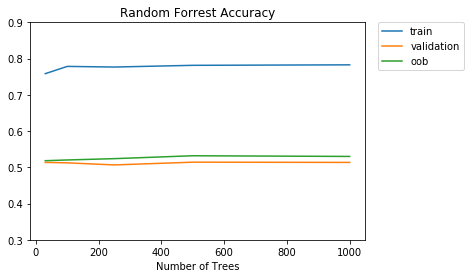

In [189]:
def plot(xs, ys, labels, title='', x_label='', y_label=''):
    for x, y, label in zip(xs, ys, labels):
        plt.ylim((0.3, 0.9))
        plt.plot(x, y, label=label)
        
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
    plt.show()

plot([n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

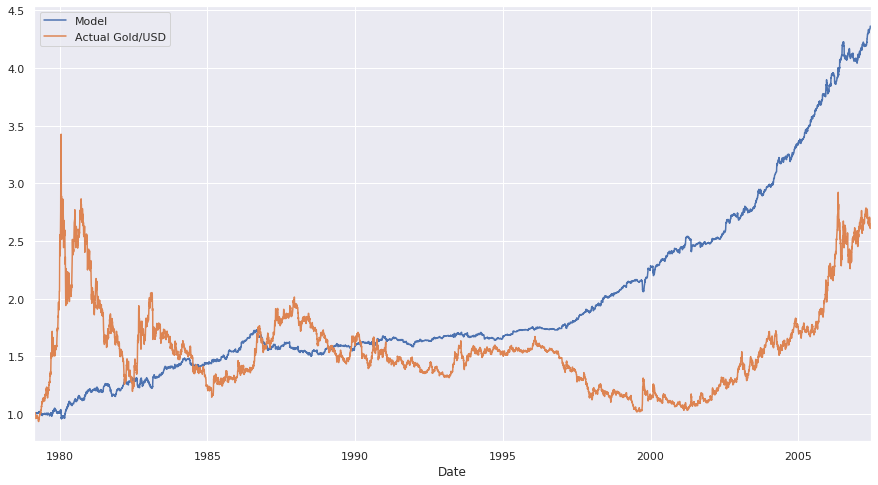

In [249]:
prob_array=[-1,1]
alpha_score = clf.predict_proba(scaled_split_data['X_train']).dot(np.array(prob_array))

# calculate daily returns
alpha_return = alpha_score * data.loc[split_data['X_train'].index, 'target'].shift(-1) * 1.827852605657414
xau_usd_return = data.loc[split_data['X_train'].index, 'target']

# calculate cumulative performance
alpha_perf = (1 + alpha_return).cumprod()
xau_usd_per = (1 + xau_usd_return).cumprod()

#alpha_return.plot()
alpha_sharpe = (np.sqrt(252.) * alpha_return.mean()) / alpha_return.std() 
xau_usd_sharpe = (np.sqrt(252.) * xau_usd_return.mean()) / xau_usd_return.std() 

alpha_perf.plot()
xau_usd_per.plot()

xau_usd_return.mean() / alpha_return.mean() 
sns.set(rc={'figure.figsize':(15, 8)})
plt.legend(labels = ['Model', 'Actual Gold/USD'])